In [47]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomCrop(256, padding=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [50]:
train_dataset = datasets.ImageFolder('./bumbu/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('./bumbu/test', transform=val_transforms)

In [51]:
class_counts = [train_dataset.targets.count(c) for c in range(len(train_dataset.classes))]
class_weights = 1. / np.array(class_counts)
sample_weights = [class_weights[t] for t in train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [52]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5), 
    nn.Linear(model.fc.in_features, len(train_dataset.classes))
)
model = model.to(device)

In [53]:
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [ ]:
train_losses, val_losses, val_accuracies = [], [], []
best_loss = float('inf')
patience, trials = 5, 0

for epoch in range(30):  
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    val_preds, val_targets = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    accuracy = correct / total
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2%}")

    if val_loss < best_loss:
        best_loss = val_loss
        trials = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model improved, saving...")
    else:
        trials += 1
        if trials >= patience:
            print("Early stopping!")
            break

    scheduler.step(val_loss)


Epoch 1, Train Loss: 1.7635, Val Loss: 1.8118, Accuracy: 47.86%
Model improved, saving...
Epoch 2, Train Loss: 1.1678, Val Loss: 2.4000, Accuracy: 51.67%
Epoch 3, Train Loss: 0.9486, Val Loss: 2.0075, Accuracy: 53.65%
Epoch 4, Train Loss: 0.8285, Val Loss: 1.3085, Accuracy: 65.16%
Model improved, saving...
Epoch 5, Train Loss: 0.6625, Val Loss: 0.8854, Accuracy: 75.63%
Model improved, saving...
Epoch 6, Train Loss: 0.6861, Val Loss: 0.8412, Accuracy: 75.71%
Model improved, saving...
Epoch 7, Train Loss: 0.6292, Val Loss: 1.0639, Accuracy: 72.62%
Epoch 8, Train Loss: 0.5476, Val Loss: 0.9852, Accuracy: 75.56%
Epoch 9, Train Loss: 0.4980, Val Loss: 1.2152, Accuracy: 72.14%
Epoch 10, Train Loss: 0.4842, Val Loss: 0.9240, Accuracy: 75.00%
Epoch 11, Train Loss: 0.2942, Val Loss: 0.4567, Accuracy: 87.30%
Model improved, saving...
Epoch 12, Train Loss: 0.2119, Val Loss: 0.5114, Accuracy: 85.63%
Epoch 13, Train Loss: 0.2128, Val Loss: 0.5446, Accuracy: 84.44%
Epoch 14, Train Loss: 0.2016, Val 

In [55]:
epochs = range(1, len(train_losses) + 1)

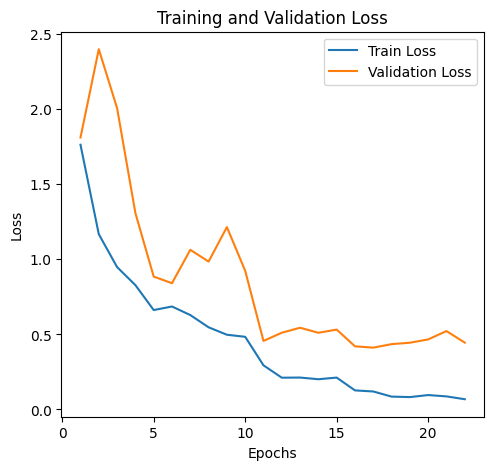

In [56]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


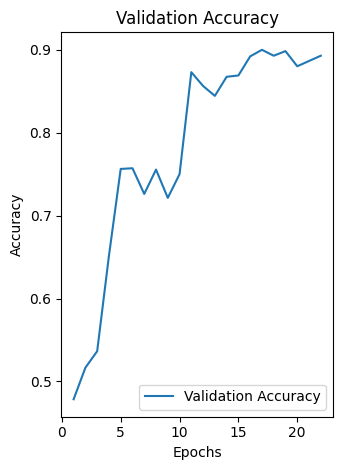

In [57]:
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

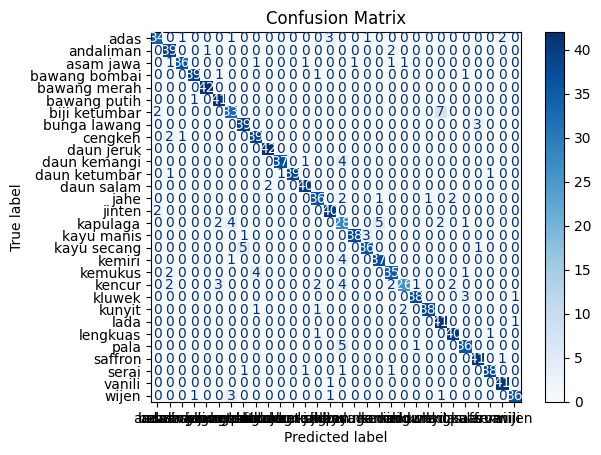

In [58]:
cm = confusion_matrix(val_targets, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()